In [1]:
%matplotlib inline

# A Script for finding relative pose between images

This script works with images that always intersects

# Part I. Preparation

First, we load the dataset. This might take a couple minutes.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import load_data
import time
import traditional
import matplotlib.pyplot as plt

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        load_data.ToTensor(),
        load_data.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        load_data.ToTensor(),
        load_data.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

pose_dataset = {x: load_data.RelativePoseDataset(csv_file='files_list.csv', root_dir='dataset', 
                transform=data_transforms[x], dataset_type=x)
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(pose_dataset[x], batch_size=10,
                shuffle=True, num_workers=10)
                for x in ['train', 'val']}

dataset_sizes = {x: len(pose_dataset[x]) for x in ['train', 'val']}

device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#check that sizes are correct!
print(dataset_sizes)


{'train': 900, 'val': 100}


- Visualize a few images
 * Let's visualize a few training images so as to understand the data augmentations.

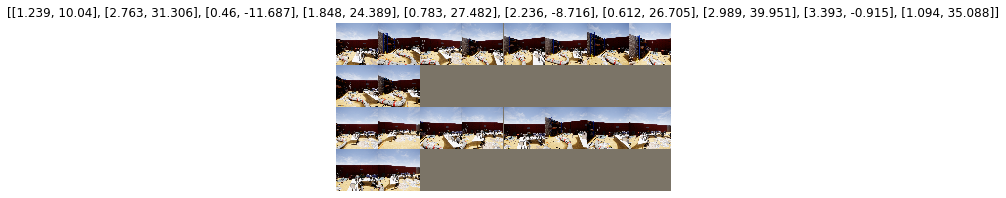

In [4]:
# Get a batch of training data and show it

load_data.show_batch( next(iter(dataloaders['train'])) )


Part II. Training the model
-------------------------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

In [5]:
def train_model(train, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = np.inf
    if train:
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    # Set model to training mode
                    model['conv1'].train()
                    model['conv2'].train()
                    model['fc'].train()
                else:
                    # Set model to evaluate mode
                    model['conv1'].eval()
                    model['conv2'].eval()
                    model['fc'].eval()

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
               
                for batch in dataloaders[phase]:                    
                   
                    img1 = batch['image1'].to(device, dtype=torch.float)
                    img2 = batch['image2'].to(device, dtype=torch.float)
                    relative = batch['relative'].to(device, dtype=torch.float)
                   
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        conv1 = model['conv1'](img1)
                        conv2 = model['conv2'](img2)
                        #print(conv2.shape)
                        # concatenate
                        fcn = torch.cat((conv1,conv2), 1)
                        outputs = model['fc'](fcn)
                    
                        loss = criterion(outputs, relative)
                        
                         # statistics
                        if phase == 'val':
                            running_corrects += loss.item()
                        
                        #print(loss)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            running_loss += loss.item()
                      
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]

                print('{} Loss: {:.7f}  Acc: {:.7f}'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc < best_acc:
                    best_acc = epoch_acc
                    torch.save(model['conv1'].state_dict(), 'conv1.pt' )
                    torch.save(model['conv2'].state_dict(), 'conv2.pt' )
                    torch.save(model['fc'].state_dict(), 'fc.pt')
            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model['conv1'].load_state_dict(torch.load( 'conv1.pt' ))
    model['conv2'].load_state_dict(torch.load( 'conv2.pt' ))
    model['fc'].load_state_dict(torch.load( 'fc.pt' ))
    return model, best_acc

#### Visualizing the model predictions

Generic function to display predictions for a few images


In [6]:
def visualize_model( model, batch_num=6, compare=False):
    
    model['conv1'].eval()
    model['conv2'].eval()
    model['fc'].eval()
    
    data_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for batch in dataloaders['val']:
            img1 = batch['image1'].to(device, dtype=torch.float)
            img2 = batch['image2'].to(device, dtype=torch.float)
            relative = batch['relative'].to(device, dtype=torch.float)
            conv1 = model['conv1'](img1)
            conv2 = model['conv2'](img2)
            # concatenate
            fcn = torch.cat((conv1,conv2), 1)
            outputs = model['fc'](fcn)
    
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            for j in range(len(img1)):
                data_so_far += 1
                name_ = outputs.cpu().data[j]    
                name_[1] = name_[1]*180/3.14159
                title =  np.around(name_.numpy().tolist(),3) 
                name2_ = relative.cpu().data[j]
                name2_[1] = name2_[1]*180/3.14159
                title2_ =  np.around(name2_.numpy().tolist(),3) 
                
                plt.figure()
        
                img_ = img1.cpu().data[j]
                img_ = img_.numpy().transpose((1, 2, 0))
                img_ = std * img_ + mean
                img_ = np.clip(img_, 0, 1)
                
                img2_ = img2.cpu().data[j]
                img2_ = img2_.numpy().transpose((1, 2, 0))
                img2_ = std * img2_ + mean
                img2_ = np.clip(img2_, 0, 1)

                grid = np.hstack( (img_, img2_) )
                plt.imshow(grid)
                
                plt.axis('off')
                plt.ioff()
                plt.show()
                np.set_printoptions(suppress=True)
                print("RGT : ", title2_)
                print("CNN : ", title)
                
                if compare:
                    translation, rotation = traditional.get_pose(img_,img2_)
                    title3_ = np.around([translation, rotation],3) 
                    print("TCV : ", title3_)
        
                if data_so_far == batch_num:
                    return
            

Finetuning the convnet
----------------------

First, a identity function is defined...


In [7]:
class IdentityModule(nn.Module):
    def forward(self, inputs):
        return inputs

In [8]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        
        self.linear1 = nn.Linear(in_features=2*2048, out_features=2048)
        self.bn1 = nn.BatchNorm1d(num_features=2048)
        self.linear2 = nn.Linear(in_features=2048, out_features=2)
        
        #self.bn1 = nn.BatchNorm1d(num_features=2*2048)
        #self.linear1 = nn.Linear(in_features=2*2048, out_features=2)
        
    def forward(self, input):
        y = F.relu(self.bn1(self.linear1(input)))
        y = self.linear2(y)
        return y

Load a pretrained model and reset final fully connected layer.

In [9]:
def init_net():
    
    model = {'conv1' : models.resnet18(pretrained=True), \
             'conv2' : models.resnet18(pretrained=True), \
             'fc'    : FC() }

    model['conv1'].fc = IdentityModule()
    model['conv2'].fc = IdentityModule()

    model['conv1'] = model['conv1'].to(device)
    model['conv2'] = model['conv2'].to(device)
    model['fc'] = model['fc'].to(device)
    
    #for param in  model['conv1'].parameters():
    #    param.requires_grad = False
    #for param in  model['conv2'].parameters():
    #    param.requires_grad = False

    criterion = nn.MSELoss(size_average=False)

    # Observe that all parameters are being optimized
    parameters = list(model['conv1'].parameters()) + list(model['conv2'].parameters()) + list(model['fc'].parameters())
    
    return model, criterion, parameters


Train and evaluate 
----------------------

If you select train=True, a eelection of random values for hyperparameters in order to get better perfomarnce.
It should take around 15-25 min.

In [10]:
train = True
if train:

    model, criterion, parameters = init_net()

    max_learning_iterations = 1
    max_step_size_iterations = 2
    max_gamma_iterations = 2
    best_acc = np.inf

    result = {'model': model, 'learning': 0, 'step': 0, 'gamma': 0}

    for learning_ in range(max_learning_iterations):
        learning = 1e-3 #np.random.uniform(1e-5, 1e-3, 1)[0]
    #    for step_size_ in range(max_step_size_iterations):
    #        step = int(np.around(np.random.uniform(5, 10, 1)))
    #        for gamma_ in range(max_gamma_iterations):
    #            gam = np.random.uniform(0.001, 0.2, 1)

        print('learning rate :', learning)
    #            print('step :', step)
    #            print('gamma :', gam[0])
        model, criterion, parameters = init_net()
        optimizer_ft = optim.Adam(parameters, lr=learning)
        #optimizer = optim.Adamax(parameters, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    # Decay LR by a factor of 0.1
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)
        model, acc = train_model(True, model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=500)


        if acc < best_acc:
            best_acc = acc
            result['model'] = model
            result['learning'] = learning
            result['step'] = 30
            result['gamma'] = 0.1


    print('best overal acc : ', best_acc)
    model = result['model']
    torch.save(model['conv1'].state_dict(), 'conv1.pt' )
    torch.save(model['conv2'].state_dict(), 'conv2.pt' )
    torch.save(model['fc'].state_dict(), 'fc.pt')

learning rate : 0.001
Epoch 0/499
----------
train Loss: 1.4597548  Acc: 0.0000000
val Loss: 0.0000000  Acc: 1.0608537

Epoch 1/499
----------
train Loss: 0.9036047  Acc: 0.0000000
val Loss: 0.0000000  Acc: 1.8226350

Epoch 2/499
----------
train Loss: 0.8840090  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.8387782

Epoch 3/499
----------
train Loss: 0.7889824  Acc: 0.0000000
val Loss: 0.0000000  Acc: 1.0642511

Epoch 4/499
----------
train Loss: 0.6764278  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.8069813

Epoch 5/499
----------
train Loss: 0.6371850  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.5808195

Epoch 6/499
----------
train Loss: 0.5744500  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6148029

Epoch 7/499
----------
train Loss: 0.5605133  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.5448308

Epoch 8/499
----------
train Loss: 0.5464487  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6185315

Epoch 9/499
----------
train Loss: 0.4326354  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.4735428

train Loss: 0.0390514  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6227911

Epoch 84/499
----------
train Loss: 0.0385272  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6652790

Epoch 85/499
----------
train Loss: 0.0399779  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6444547

Epoch 86/499
----------
train Loss: 0.0308994  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6616073

Epoch 87/499
----------
train Loss: 0.0388261  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6871548

Epoch 88/499
----------
train Loss: 0.0352026  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6320245

Epoch 89/499
----------
train Loss: 0.0343912  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6071491

Epoch 90/499
----------
train Loss: 0.0421243  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6034734

Epoch 91/499
----------
train Loss: 0.0389913  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6371723

Epoch 92/499
----------
train Loss: 0.0378734  Acc: 0.0000000
val Loss: 0.0000000  Acc: 0.6584195

Epoch 93/499
----------
train Loss

KeyboardInterrupt: 

Use the best params to train more time if train was set ...

In [11]:
model, criterion, parameters = init_net()
optimizer_ft = optim.Adam(parameters, lr=0.01)
# Decay LR by a factor of 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
model, acc = train_model(False, model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=120)

<Figure size 432x288 with 0 Axes>

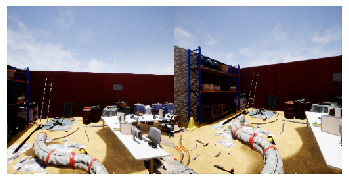

RGT :  [  1.75  -32.284]
CNN :  [  2.301 -23.553]
TCV :  [ 0.46  -0.297]


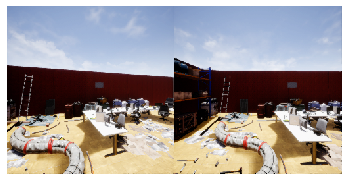

RGT :  [  0.069 -15.777]
CNN :  [  0.914 -13.398]
TCV :  [ 0.045 -0.522]


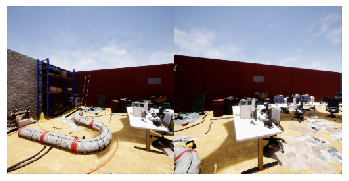

RGT :  [ 1.7   38.668]
CNN :  [ 1.361 33.726]
TCV :  [  0.713 -39.233]


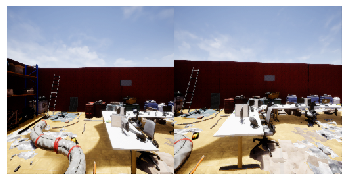

RGT :  [1.43  7.449]
CNN :  [1.168 3.959]
Not enough matches are found - %d/%d 6 10
TCV :  [0 0]


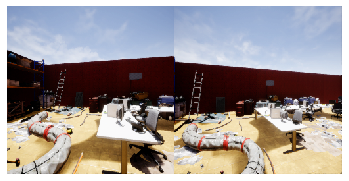

RGT :  [ 2.412 29.104]
CNN :  [ 2.149 30.054]
TCV :  [   7.344 -172.302]


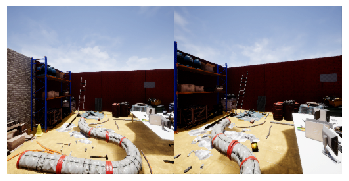

RGT :  [ 2.877 -9.808]
CNN :  [ 2.122 -6.841]
Not enough matches are found - %d/%d 5 10
TCV :  [0 0]


In [13]:
visualize_model(model, compare=True)